In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_palette("GnBu_d")
sns.set_style('whitegrid')


In [ ]:
car_data = pd.read_csv("https://raw.githubusercontent.com/kapilthakre/Predicting-the-Price-of-Used-Cars/master/Datasets/car_price_data1.csv")
print(car_data.head())

In [ ]:
car_data.describe(include='all')

In [ ]:
# Information of the data
car_data.info()

In [ ]:
# In Model column There are three hundred and twelve unique models. 
# That's something really hard to implement and a regression that would mean more than 300 dummies,
df = car_data.drop(labels='Model', axis=1)
#Cheking missing value
df.isna().sum()
# so we are simply droping all nan values, and this is not always recommended, 
# however when we remove less than 5% of the data, then it is okay
df_no_mv = df.dropna()

In [ ]:
# This makes it very easy to spot anomalies, such as outliers/ Analyzing the column of dataset
plt.figure(figsize=[11,6])
sns.distplot(df_no_mv['Price'])
plt.title('Car Price Distribution Plot')
# car and mileage Distribution Plot
plt.figure(figsize=[17,5])
plt.subplot(1,3,1)
sns.distplot(df_no_mv['Year'])
plt.title('Car Year Distribution Plot')

plt.subplot(1,3,2)
sns.distplot(df_no_mv['Mileage'])
plt.title('Car Mileage Distribution Plot')

plt.subplot(1,3,3)
sns.distplot(df_no_mv['EngineV'])
plt.title('EngineV Distribution Plot')

In [ ]:
# Here, the outliers are situated around the higher prices (right side of the graph)
# we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples
# This is a dataset about used cars, therefore one can imagine how $300,000 is an excessive price
# Outliers are a great issue for OLS, thus we must deal with them in some way

# Let's declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = df_no_mv['Price'].quantile(0.99)
# Then we can create a new df, with the condition that all prices must be below the 99 percentile of 'Price'
data_1 = df_no_mv[df_no_mv['Price']<q]

In [ ]:
#check the PDF once again
plt.figure(figsize=[11,5])
sns.distplot(data_1['Price'])
plt.title('Car Price Distribution Plot')

In [ ]:
#Now we can treat the other numerical variables outlier in a similar way
sns.distplot(df_no_mv['Mileage'])
plt.title('Car Mileage Distribution Plot')

In [ ]:
#Here we finding 99th percetile value of mileage 
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]
sns.distplot(data_2['Mileage'])

In [ ]:
# In this scenario outliers are on the low end
sns.distplot(df_no_mv['Year'])

In [ ]:
q = data_2['Year'].quantile(0.01)
data_3 = data_2[data_2['Year']>q]
sns.distplot(data_3['Year'])

In [ ]:
# The situation with engine volume is very strange
# In such cases it makes sense to manually check what may be causing the problem
# In our case the issue comes from the fact that most missing values are indicated with 99.99 or 99
# There are also some incorrect entries like 75
sns.distplot(df_no_mv['EngineV'])
plt.title('EngineV Distribution Plot')

In [ ]:
# Car engine volumes are usually (always?) below 6.5l, You can google it
# This is a prime example of the fact that a domain expert (a person working in the car industry)
# may find it much easier to determine problems with the data than an outsider
data_4 = data_3[data_3['EngineV']<6.5]

In [ ]:
# now its looks kind of normal
sns.distplot(data_4['EngineV'])

In [ ]:
# Reset index
cleaned_data = data_4.reset_index(drop=True)

In [ ]:
# once again checking discriptive statistics
cleaned_data.describe()

In [ ]:
#Scatter Plot of independent variables vs dependent variables
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and Year")
sns.scatterplot(x='Year',y='Price',data=cleaned_data)

plt.subplot(1,3,2)
plt.title("Price and Mileage")
sns.scatterplot(x='Price',y='Mileage',data=cleaned_data)

plt.subplot(1,3,3)
sns.scatterplot(y='Price',x='EngineV',data=cleaned_data)
plt.title("Price and EngineV")

In [ ]:
#recall the distribution plot of price
sns.distplot(cleaned_data['Price'])

In [ ]:
# Let's transform 'Price' with a log transformation
log_price = np.log(cleaned_data['Price'])

# Then we add it to our data frame
cleaned_data['log_price'] = log_price
cleaned_data.head()


In [ ]:
# Let's check the three scatters once again

plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Log price and Year")
sns.scatterplot(x='Year',y='log_price',data=cleaned_data)

plt.subplot(1,3,2)
plt.title("Log price and Mileage")
sns.scatterplot(y='log_price',x='Mileage',data=cleaned_data)

plt.subplot(1,3,3)
sns.scatterplot(y='log_price',x='EngineV',data=cleaned_data)
plt.title("Log price and EngineV")

# The relationships show a clear linear relationship
# This is some good linear regression material

In [ ]:
# Since we will be using the log price variable, we can drop the old 'Price' one
cleaned_data = cleaned_data.drop(['Price'],axis=1)

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = cleaned_data[['Mileage','Year','EngineV']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns
vif

,VIF,Features
0,3.791584,Mileage
1,10.354854,Year
2,7.662068,EngineV


In [28]:
# 'Year' has high VIF so we are just droping that column
# So even if EngineV seems with a high VIF, too, once 'Year' is gone that will no longer be the case
data_no_multicolinearity = cleaned_data.drop('Year',axis=1)
data_no_multicolinearity.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,log_price
0,BMW,sedan,277,2.0,Petrol,yes,8.342840
1,Mercedes-Benz,van,427,2.9,Diesel,yes,8.974618
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,9.495519
3,Audi,crossover,240,4.2,Petrol,yes,10.043249
4,Toyota,crossover,120,2.0,Petrol,yes,9.814656


In [29]:
from sklearn.preprocessing import LabelEncoder
temp_data = data_no_multicolinearity.copy()
for col in temp_data.columns:
    if temp_data[col].dtypes == 'object':
        encoder = LabelEncoder()
        temp_data[col] = encoder.fit_transform(temp_data[col])
        
# Correated Features with target variable
print('\n--Correated Features with target variable--\n')
print(abs(temp_data.corrwith(temp_data['log_price'])).sort_values(ascending=False)[1:])


--Correated Features with target variable--

Mileage         0.614806
Registration    0.462986
EngineV         0.411935
Body            0.387294
Brand           0.099597
Engine Type     0.014890
dtype: float64


<AxesSubplot: >

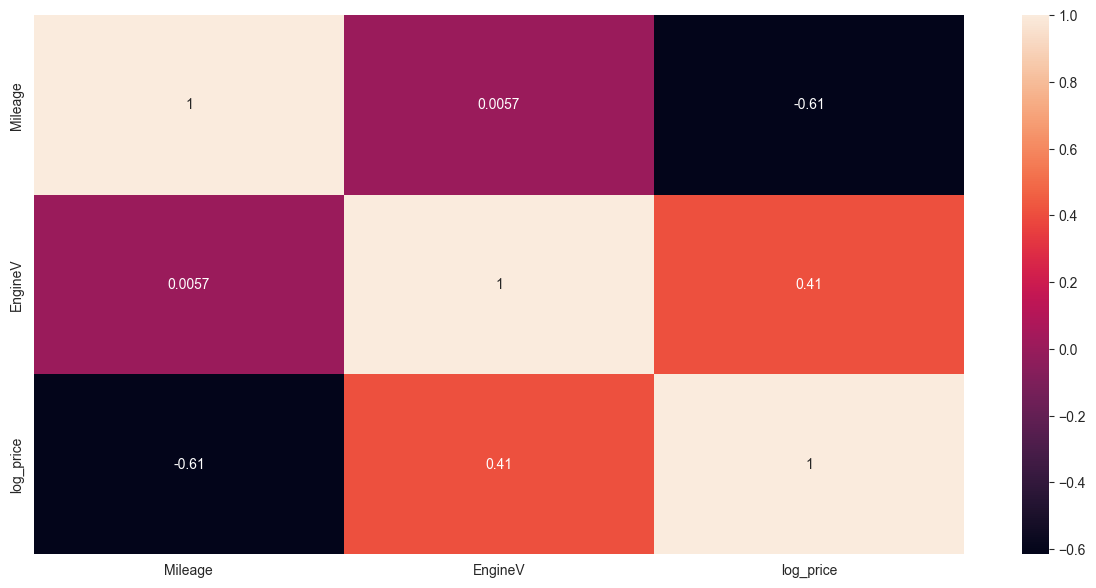

In [30]:
# correlation heat map
plt.figure(figsize=[15,7])
sns.heatmap(data_no_multicolinearity.corr(), annot=True)

In [31]:
# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
X = temp_data.drop('log_price',axis=1)
y = temp_data['log_price']
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

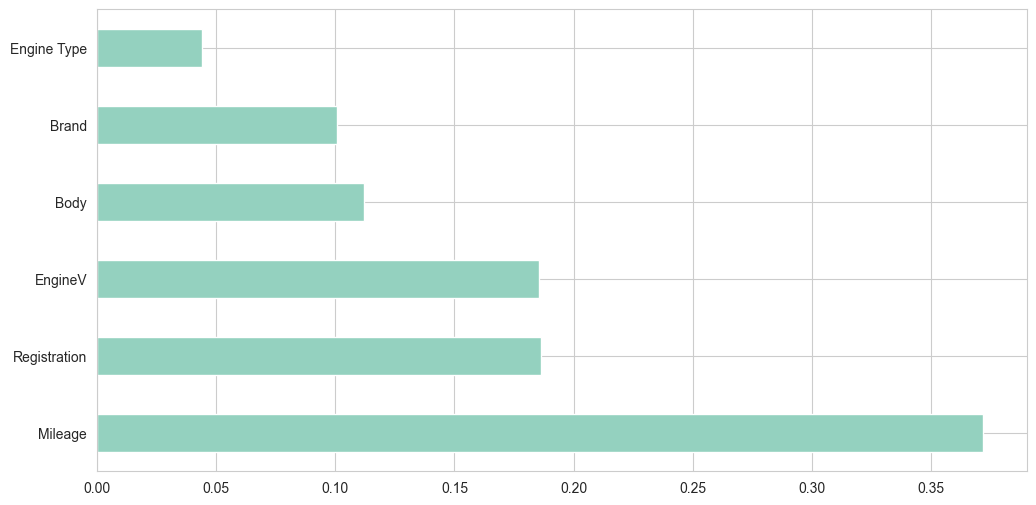

In [32]:
# plot graph of feature importances for better visualization
plt.figure(figsize=[12,6])
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

In [33]:
print(feat_importances.sort_values(ascending=False))

Mileage         0.371553
Registration    0.186399
EngineV         0.185281
Body            0.112205
Brand           0.100568
Engine Type     0.043993
dtype: float64


In [34]:
#Creating Dummie Variables
data_with_dummies = pd.get_dummies(data_no_multicolinearity,drop_first=True)

In [35]:
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [36]:
#Creating and declaring Dependent and indepedent variable
x = data_with_dummies.drop('log_price',axis=1)
y = data_with_dummies['log_price']

In [37]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x[['Mileage','EngineV']])

StandardScaler()

In [39]:
# It is not usually recommended to standardize dummy variables
#For ML purposes we rarely put too much thought into it and go with the scale dummies as 
#scaling has no effect on their predictive power.
inputs_scaled = scaler.transform(x[['Mileage','EngineV']])
scaled_data = pd.DataFrame(inputs_scaled,columns=['Mileage','EngineV'])
input_scaled2 =scaled_data.join(x.drop(['Mileage','EngineV'],axis=1))

In [40]:
#Training and Testing the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_scaled2,y,test_size=0.2, random_state=365)

In [43]:
#Linear Regression Model
# Model Building
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Training Model
lr.fit(x_train,y_train)

# Model Summary
y_pred_lr = lr.predict(x_test)

r_squared = r2_score(y_test,y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_lr))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.7726984972665855
RMSE : 0.4298206539563801


In [44]:
#Random Forest Regressor Model
# Model Building
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

# Training Model
rf.fit(x_train,y_train)

# Model Summary
y_pred_rf = rf.predict(x_test)

r_squared = r2_score(y_test,y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_rf))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.8090218443475999
RMSE : 0.39398344609321667


In [45]:
#Grading Boosting Regressor model
# Model Building
from sklearn.ensemble import GradientBoostingRegressor
gbt = GradientBoostingRegressor()

# Training Model
gbt.fit(x_train,y_train)

# Model Summary
y_pred_gbt = gbt.predict(x_test)

r_squared = r2_score(y_test,y_pred_gbt)
rmse = np.sqrt(mean_squared_error(y_test,y_pred_gbt))
print("R_squared :",r_squared)
print("RMSE :",rmse)

R_squared : 0.8125859354718367
RMSE : 0.3902898139101987


In [46]:
#Selecting Best Model
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_gbt))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_gbt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbt)))
#So as we try diferent Regression Alorithms and found that "GBT Regressor Model" is giving better accuracy compare to other.

MAE: 0.28799288828712005
MSE: 0.1523261388420575
RMSE: 0.3902898139101987


In [47]:
#Let's Manually Chek the Value
# Finally, let's manually check these predictions
# To obtain the actual prices, we take the exponential of the log_price
df_ev = pd.DataFrame(np.exp(y_pred_gbt), columns=['Predicted Price'])

# We can also include the Actual price column in that data frame (so we can manually compare them)
y_test = y_test.reset_index(drop=True)
df_ev['Actual Price'] = np.exp(y_test)

# we can calculate the difference between the targets and the predictions
df_ev['Residual'] = df_ev['Actual Price'] - df_ev['Predicted Price']
df_ev['Difference%'] = np.absolute(df_ev['Residual']/df_ev['Actual Price']*100)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_ev.sort_values(by=['Difference%'])

df_ev.tail(5)

,Predicted Price,Actual Price,Residual,Difference%
769,24080.20,29500.00,5419.80,18.37
770,9552.79,9600.00,47.21,0.49
771,14320.47,18300.00,3979.53,21.75
772,29363.56,68500.00,39136.44,57.13
773,11213.79,10800.00,-413.79,3.83
